In this file we create an AI that discriminates its opponents roles as the game progresses.

In [180]:
import torch
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import numpy as np

from tqdm.notebook import tqdm

import json, os

In [181]:
def to_cuda(sample):
    sample['inputs'] = list(torch.tensor(i, device='cuda') for i in sample['inputs'])
    return sample

class SHDataset(Dataset):
    def __init__(self, root_dir='data/parsed', transform=None, validation=False):
        self.root_dir = root_dir
        self.transform = transform
        self.len = len(os.listdir(root_dir))
        self.validation = validation
        if validation:
            self.start_idx = 1 + (self.len*9)//10
            self.len = self.len - self.start_idx + 1
        else:
            self.start_idx = 1
            self.len = (self.len*9)//10
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            print(idx)
            raise Exception("I don't know why it would ever be a tensor...!")
        filename = os.path.join(self.root_dir, f'{self.start_idx+idx}.txt')
        sample = json.load(open(filename))
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

In [182]:
dataset = SHDataset()
validation_dataset = SHDataset(validation=True)

In [207]:
import random

def random_game():
    d = random.choice(dataset)
    actions = torch.tensor(d['inputs']).float().cuda()
    roles = torch.tensor(d['roles']).cuda()
    return actions, roles

# minibatch currently won't work (need to take into account varying game lengths)
def minibatch(batch_size=100):
    batch_actions = []
    batch_roles = []
    for i in range(batch_size):
        d = random.choice(dataset)
        batch_actions.append(torch.tensor(d['inputs']))
        batch_roles.append(d['roles'])
    batch_actions = pad_sequence(batch_actions).cuda().float()
    batch_roles = torch.tensor(batch_roles, device='cuda')
    return batch_actions, batch_roles

def not_random_game(idx):
    d = datasets[idx]
    actions = list(map(lambda x: torch.tensor(x, device='cuda'), d['inputs']))
    roles = torch.tensor(d['roles']).cuda()
    return actions, roles

In [208]:
class Discriminator(nn.Module):
    def __init__(self, input_size=54, hidden_size=100, output_size=21, n_layers=1, dropout=0):
        super(Discriminator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_size, hidden_size, n_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, action, hidden):
        output = action.unsqueeze(0)
        if len(output.shape) == 2:
           output.unsqueeze_(0)
        output, hidden = self.gru(output, hidden)
        output = self.linear(output).reshape([-1, 3, 7])
        return output, hidden
    
    def init_hidden(self, batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).cuda()

In [443]:
roles = torch.tensor([[0, 0, 0, 0, 1, 2, 1] for i in range(10)])
r = torch.zeros(*roles.shape, 3)
for i, b in enumerate(roles):
    for j, d in enumerate(b):
        r[i, j, d] = 1
r[0]

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]])

In [480]:
def train(actions, roles, batch_size=1):
    h = model.init_hidden(batch_size=batch_size)
    avg_acc = 0
    avg_loss = 0
    
    initial_loss = None
    initial_acc = None
    
    r = torch.zeros(*roles.shape, 3)
    for i, b in enumerate(roles):
        for j, d in enumerate(b):
            r[i, j, d] = 1
    onehot = r.cuda()
    
    loss = 0
    cnt = 0
    for turn, action in enumerate(actions):
        output, h = model(action, h.detach())
        cnt += 1
        l = criterion(output.transpose(1, 2), onehot)
        loss = l
        acc = accuracy(output.detach(), roles)
        avg_loss += float(l)
        avg_acc += acc
        if initial_loss is None:
            initial_loss = float(l)
            initial_acc = acc
        loss.backward()
    end_loss = float(l)
    end_acc = acc
    optim.step()
    optim.zero_grad()
    avg_loss /= cnt
    avg_acc /= cnt
    return np.array([avg_loss, initial_loss, end_loss]), np.array([avg_acc, initial_acc, end_acc])

def accuracy(output, roles):
    if len(output.shape) == 2:
        output = [output]
        roles = [roles]
    right = 0
    for o, r in zip(output, roles):
        probs = torch.sum(F.softmax(o.detach())[:,1:], dim=1).cpu().numpy()
        fas = probs.argsort()[-3:][::-1]
        actual = np.array(r.cpu()).argsort()[-3:][::-1]
        for f in fas:
            if f in actual:
                right += 1
    return right/3/len(output)

In [548]:
import time
import gc
gc.collect()

n_epochs = 20000
lr = 1e-4
batch_size = 10

losses = []
accs = []
loss_sums = np.array([0, 0, 0], dtype='float32')
acc_sums = np.array([0, 0, 0], dtype='float32')
plot_every = 100

In [549]:
model = Discriminator(hidden_size=1000, n_layers=5, dropout=0.1).cuda()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0e-3)
#criterion = nn.CrossEntropyLoss()
criterion = nn.L1Loss()

In [550]:
progress_bar = tqdm(range(1, n_epochs+1))

i = 0
for epoch in progress_bar:
    loss_, acc_ = train(*minibatch(batch_size), batch_size)
    loss_sums += loss_
    acc_sums += acc_
    i += 1
    
    progress_bar.set_description('loss: %.4f, acc: %.2f'% (loss_sums[0]/i, 100*acc_sums[0]/i))
    
    if epoch % plot_every == 0:
        losses.append(loss_sums / plot_every)
        accs.append(acc_sums / plot_every)
        loss_sums = 0
        acc_sums = 0
        i = 0

c:\python37\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


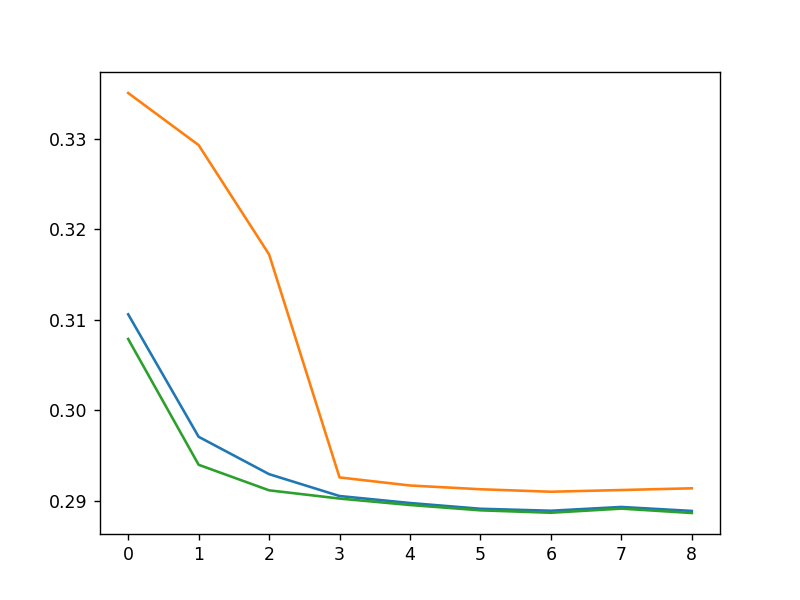

[0.42674074 0.42674074 0.42674074]


In [553]:
%matplotlib notebook
import matplotlib.pyplot as plt
#plt.plot(accs)
plt.plot(np.array(losses)[:,0:3])
print(sum(accs)/len(accs))
plt.show()

In [554]:
def parse_action(inpts):
    action = inpts.tolist()
    return action[7] + action[8] > 0, action[7]

def print_guesses(output, libs, fas):
    #print("\n")
    #print("Running total:", libs, fas)
    
    # prob that someone is fas or hitty:
    output = output.squeeze(0).transpose(0, 1)
    probs = torch.sum(F.softmax(output.detach())[:,1:2], dim=1).tolist()
    probs = list(map(lambda x: '%.2f'%x, probs))
    #print(*probs)
    #print("Probs:", *probs)
    
    # fas/hitty guesses
    guesses = F.softmax(output.detach().cpu()).numpy()
    probs = list(map(lambda x: '%.2f'%x, guesses[:,0]))
    print(guesses)
    #print(*probs)
    hitty = np.argmax(guesses[:,2])
    fas = guesses[:,1].argsort()[-2:][::-1]
    #print("Most hitty:", hitty)
    #print("Most fas:", *fas)
    #print("\n")

def play_game():
    actions, roles = random_game()
    print("Actual roles:", roles.tolist())
    
    h = model.init_hidden()
    libs = 0
    fas = 0
    
    first = True
    for action in actions:
        output, h = model(action, h.detach())
        if first:
            first = False
            print_guesses(output, libs, fas)
        policy_enacted, policy = parse_action(action)
        if policy_enacted:
            if policy == 1:
                libs += 1
            else:
                fas += 1
    print_guesses(output, libs, fas)
    print("Actual roles:", roles.tolist())
play_game()

Actual roles: [0, 2, 0, 1, 1, 0, 0]
[[0.5720641  0.21285489 0.21508098]
 [0.5760724  0.2132775  0.21065018]
 [0.57862234 0.20990546 0.21147218]
 [0.57792753 0.21132408 0.21074843]
 [0.5738516  0.21216641 0.21398199]
 [0.57451457 0.21236204 0.21312337]
 [0.57339483 0.21194185 0.21466333]]
[[0.56027204 0.22003444 0.21969351]
 [0.56510377 0.21841156 0.2164846 ]
 [0.5652886  0.2170742  0.21763714]
 [0.5748751  0.2124456  0.21267919]
 [0.56075317 0.21992683 0.21932001]
 [0.5656116  0.21757711 0.21681134]
 [0.5688665  0.21413495 0.2169986 ]]
Actual roles: [0, 2, 0, 1, 1, 0, 0]


c:\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
c:\python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
